# Lab 2:  Model Estimation and Discriminant Functions

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

## 4  Sequential Discriminants

### Helper Functions and Importing of the Dataset

In [119]:
def MED(mu_a, mu_b, X, Y):
    dist = np.zeros((len(X), len(X[0])), dtype=np.int)
    #print(len(dist), len(dist[0]))
    for i in range(len(X)):
        for j in range(len(X[0])):
            classifier = [X[i,j], Y[i,j]]
            #print(i, j, classifier, mu_a, mu_b)
            a = np.linalg.norm(classifier-mu_a) #set 1
            b = np.linalg.norm(classifier-mu_b) #set 2
            if a < b:
                dist[i,j] = -1
            elif b < a:
                dist[i,j] = 1
    return dist

#----------------------------------------------------------------------------#

def ellipse(mean, eigenvalues, theta, points):
    a = np.sqrt(eigenvalues[0])
    b = np.sqrt(eigenvalues[1])
    h = mean[0]
    k = mean[1]
    angle = theta*np.pi/180
    
    t = np.linspace(0, 2*np.pi, points)
    
    x = a*np.cos(t)
    y = b*np.sin(t)
    
    x_prime = x*np.cos(theta) - y*np.sin(theta) + h
    y_prime = x*np.sin(theta) - y*np.cos(theta) + k
    
    return x_prime,y_prime

#----------------------------------------------------------------------------#

def classify(input_vec, dist, X, Y, h):
    xs = X[0]
    if input_vec[0] <= xs[0]:
        i = 0
    elif input_vec[0] >= xs[-1]:
        i = len(xs) - 1
    else:
        i = int(round((input_vec[0] - xs[0]) / h))
    
    ys = Y[:,0]
    if input_vec[1] <= ys[0]:
        j = 0
    elif input_vec[1] >= ys[-1]:
        j = len(ys) - 1
    else:
        j = int(round((input_vec[1] - ys[0]) / h))
    
    return dist[j][i]
    
def getConfusionMatrix(dist, classes, labels, X, Y, h):
    dim = len(classes)
    cm = np.zeros((dim, dim + 1))
    a_indices = []
    b_indices = []
    for i, cls in enumerate(classes):
        for j, data in enumerate(cls):   
            result = labels.index(classify(data, dist, X, Y, h))
            if i==0 and result==0:
                a_indices.append(j) #correctly classified A
            if i==1 and result==1:
                b_indices.append(j) #correctly classified B          
            cm[i][result] += 1
    return cm, a_indices, b_indices

def roundup(x):
    return int(np.ceil(x / 10.0)) * 10


def get_dist_indices(dist, X, Y, point):
    xs = X[0]
    ys = Y[:, 0]
    
    x_min = xs[0]
    dx = xs[1] - xs[0]
    y_min = ys[0]
    dy = ys[1] - ys[0]
    
    max_i = len(xs) - 1
    max_j = len(ys) - 1
    
    i = int(np.around((point[0] - x_min) / dx))
    j = int(np.around((point[1] - y_min) / dy))
    i = max_i if i > max_i else i
    j = max_j if j > max_j else j
    
    return i, j

def get_n_aB(dist, X, Y, a_samples):
    count = 0
    indices = []
    for index, point in enumerate(a_samples):
        i, j = get_dist_indices(dist, X, Y, point)
        if dist[j,i] != -1:
            count += 1
        else:
            indices.append(index)
    return count, indices

def get_n_bA(dist, X, Y, b_samples):
    count = 0
    indices = []
    
    for index, point in enumerate(b_samples):
        i, j = get_dist_indices(dist, X, Y, point)
        if dist[j,i] != 1:
            count += 1
        else:
            indices.append(index)
    return count, indices

In [10]:
#get class a samples
data_bl = []
with open('lab2_3_a.txt','r') as f:
    for line in f.readlines():
        if(line.rstrip()):
            line = line[1:]
            data_bl.append([float(s) for s in line.split(' ')])
A_samples_seq = np.asarray(data_bl)


#get data set cl
data_cl = []
with open('lab2_3_b.txt','r') as f:
    for line in f.readlines():
        if(line.rstrip()):
            line = line[1:]
            data_cl.append([float(s) for s in line.split(' ')])
B_samples_seq = np.asarray(data_cl)

print(A_samples_seq.shape, B_samples_seq.shape)

(200, 2) (200, 2)


In [4]:
n_a = 200
mu_a = np.array([15, 10])
cov_a = np.array([[8, 0], [0, 8]])
samples_a = (np.random.multivariate_normal(mu_a, cov_a, n_a))
eigval_a, eigvec_a = np.linalg.eig(cov_a)
theta1a = np.arctan(eigvec_a[1][0]/eigvec_a[0][0])

n_b = 200
mu_b = np.array([10, 25])
cov_b = np.array([[8, 0], [0, 8]])
eigval_b, eigvec_b = np.linalg.eig(cov_b)
theta1b = np.arctan(eigvec_b[1][0]/eigvec_b[0][0])
samples_b = (np.random.multivariate_normal(mu_b, cov_b, n_b))

ellipse_a_x, ellipse_a_y = ellipse(mu_a, eigval_a, theta1a, 100)
ellipse_b_x, ellipse_b_y = ellipse(mu_b, eigval_b, theta1b, 100)


## Sequential Classifier Using Random Prototype

In [127]:
import random
# samples_a = np.array([np.round(np.abs(np.random.normal(1, 0.15, 2)*100)) for i in range(100)])
# samples_b = np.array([np.round(np.abs(np.random.normal(1.5, 0.15, 2)*100)) for i in range(100)])
# samples_a = A_samples_seq
# samples_b = B_samples_seq

X = np.concatenate((A_samples_seq,B_samples_seq), axis = 0)
x_min, x_max = np.floor(X[:, 0].min()), np.ceil(X[:, 0].max())+1
y_min, y_max = np.floor(X[:, 1].min()), np.ceil(X[:, 1].max())+1
h=1
#h = np.round(1/roundup(max(np.int(x_max),np.int(y_max)) - min(np.int(x_min),np.int(y_min))),3)

print(h, x_min, x_max, y_min, y_max)

xx, yy = np.meshgrid(np.arange(x_min, x_max+h, h),
                     np.arange(y_min, y_max+h, h))

def train_sequential(samples_a=A_samples_seq, samples_b=B_samples_seq):
    print("training sequential")
    n_aB, n_bA, i, j, J = 1,1,0,1,20
    discriminants = []
    matrices = []
    n_aBs = []
    n_bAs = []

    for j in range(J):
        #print(len(samples_a), len(samples_b))

        while( (n_aB != 0 and n_bA != 0) and (len(samples_a)!=0 and len(samples_b)!=0)):
            #print("")
            #print("Part 2 reached")

            random_a = samples_a[np.random.choice(len(samples_a))]
            random_b = samples_b[np.random.choice(len(samples_b))]

            MED_dist = MED(random_a, random_b, xx, yy)
            #confusion_matrix, a_indices, b_indices = getConfusionMatrix(MED_dist, [samples_a, samples_b], [-1, 1, 0], xx, yy, h)

            n_aB, a_indices = get_n_aB(MED_dist, xx, yy, samples_a)
            n_bA, b_indices = get_n_bA(MED_dist, xx, yy, samples_b)

        discriminants.append(MED_dist)
        matrices.append(confusion_matrix)
        n_aBs.append(n_aB)
        n_bAs.append(n_bA)
        #print(n_aB, n_bA)
        #print("Part 7 reached")
        if n_aB==0:
            #print("Cutting down on B")
            samples_b = [v for i, v in enumerate(samples_b) if i not in b_indices]

        if n_bA==0:
            #print("Cutting down on A")
            #remove points from a that G classifies as A
            samples_a = [v for i, v in enumerate(samples_a) if i not in a_indices]

        #print("Len of samples A and B", len(samples_a), len(samples_b))
        #print(len(a_indices), len(b_indices))

        n_aB, n_bA = 1,1 #reset markers to non zero 
        if len(samples_a)==0 and len(samples_b)==0:
            #print("done")
            break

    #print("Iterations: ",j)
    print("Misclassified a points as B:",n_aBs)
    print("Misclassified b points as A:",n_bAs)
    return discriminants, n_aBs, n_bAs

1 84.0 527.0 2.0 421.0


## Testing the Sequential Classifier on Training Data

In [116]:
dist_4 = np.zeros((len(xx), len(xx[0])), dtype=np.int)
for k in range(len(xx)):
    for i in range(len(xx[0])):
        done = False
        for j in range(len(discriminants)):
            disc = discriminants[j]
            if disc[k,i]==1 and n_aBs[j]==0:
                dist_4[k,i] = 1
                done = True
                break
            if disc[k,i]==-1 and n_bAs[j]==0:
                dist_4[k,i] = -1
                done = True
                break
            if j == (len(discriminants)-1) and not done:
                print("Not classified", k, i, disc[k,i])

## Plotting

[[ 1  1  1 ... -1 -1 -1]
 [ 1  1  1 ... -1 -1 -1]
 [ 1  1  1 ... -1 -1 -1]
 ...
 [ 1  1  1 ...  1  1  1]
 [ 1  1  1 ...  1  1  1]
 [ 1  1  1 ...  1  1  1]]


/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:942: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'edgecolors'
  s)


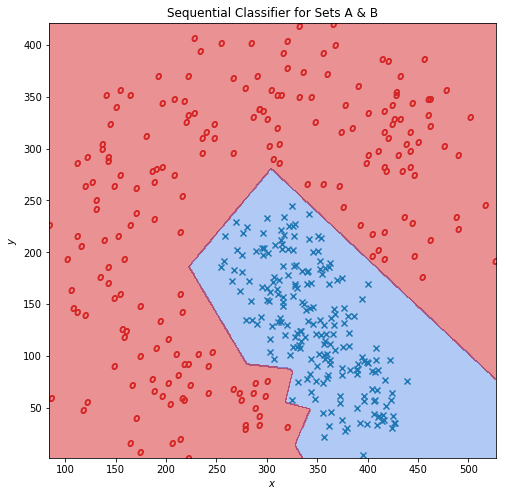

In [117]:
dist_plot = dist_4

plt.figure(1, figsize=(8,8))
plt.contourf(xx,yy,dist_plot, edgecolors='face', linewidths='10', alpha=0.5, colors=('cornflowerblue', 'tab:red', 'tab:purple'))
plt.scatter(A_samples_seq[:, 0], A_samples_seq[:, 1], marker='x');
plt.scatter(B_samples_seq[:, 0], B_samples_seq[:, 1], c='tab:red', marker='$o$')
plt.plot(mu_a[0], mu_a[1], c='limegreen', marker='H', markersize=8, alpha=0.5)
plt.plot(mu_b[0], mu_b[1], c='limegreen', marker='H', markersize=8, alpha=0.5)
plt.plot(ellipse_a_x, ellipse_a_y, color='k', alpha=0.5)
plt.plot(ellipse_b_x, ellipse_b_y, color='k', alpha=0.5)
plt.title("Sequential Classifier for Sets A & B")
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max]);

## Testing Classifiers with Different J Values

In [129]:
Js = [1, 2, 3, 4, 5]
errors = np.zeros((5, 20))
As = A_samples_seq
Bs = B_samples_seq

d_list = []
nab_list = []
nba_list = []

for d in range(20):
    discriminants, n_aBs, n_bAs = train_sequential()
    d_list.append(discriminants)
    nab_list.append(n_aBs)
    nba_list.append(n_bAs)
    
for J_val in Js:
    for itr in range(20):
        discriminants = d_list[itr]
        n_aBs = nab_list[itr]
        n_bAs = nba_list[itr]
        itr_errors = 0
        for class_i, samples in enumerate([As, Bs]):
            for s in samples:
                done = False
                i, k = get_dist_indices(discriminants[0], xx, yy, s)
                for j in range(J_val):
                    disc = discriminants[j]
                    if disc[k,i]==1 and n_aBs[j]==0:
                        if class_i == 0:
                            itr_errors += 1
                        done = True
                        break
                    if disc[k,i]==-1 and n_bAs[j]==0:
                        if class_i == 1:
                            itr_errors += 1
                        done = True
                        break
                if not done:
                    itr_errors += 1
        errors[J_val - 1][itr] = itr_errors
        
print(errors)

training sequential
Misclassified a points as B: [0, 0, 0, 50, 18, 1, 0]
Misclassified b points as A: [108, 38, 2, 0, 0, 0, 0]
training sequential
Misclassified a points as B: [0, 0, 0, 100, 0, 31, 5, 0]
Misclassified b points as A: [88, 28, 12, 0, 10, 0, 0, 0]
training sequential
Misclassified a points as B: [0, 0, 0, 0, 134, 0, 0, 85, 0, 25, 0]
Misclassified b points as A: [140, 66, 17, 6, 0, 5, 4, 0, 1, 0, 0]
training sequential
Misclassified a points as B: [0, 0, 0, 0, 0, 0, 103, 2, 0]
Misclassified b points as A: [121, 64, 36, 17, 12, 4, 0, 0, 0]
training sequential
Misclassified a points as B: [0, 0, 0, 0, 0, 14, 4, 1, 0, 0]
Misclassified b points as A: [87, 29, 19, 10, 4, 0, 0, 0, 1, 0]
training sequential
Misclassified a points as B: [0, 0, 0, 0, 143, 0, 66, 4, 0, 0]
Misclassified b points as A: [101, 42, 19, 5, 0, 4, 0, 0, 1, 0]
training sequential
Misclassified a points as B: [0, 0, 0, 0, 143, 127, 0, 9, 6, 0, 1, 0]
Misclassified b points as A: [132, 86, 17, 8, 0, 0, 4, 0, 0,

/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:942: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'edgecolors'
  s)


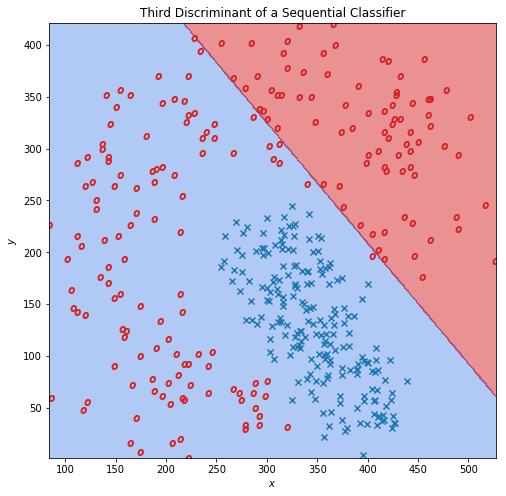

In [148]:
plt.figure(1, figsize=(8,8))
plt.contourf(xx,yy,d_list[0][2], edgecolors='face', linewidths='10', alpha=0.5, colors=('cornflowerblue', 'tab:red', 'tab:purple'))
plt.scatter(A_samples_seq[:, 0], A_samples_seq[:, 1], marker='x');
plt.scatter(B_samples_seq[:, 0], B_samples_seq[:, 1], c='tab:red', marker='$o$')
plt.plot(mu_a[0], mu_a[1], c='limegreen', marker='H', markersize=8, alpha=0.5)
plt.plot(mu_b[0], mu_b[1], c='limegreen', marker='H', markersize=8, alpha=0.5)
plt.plot(ellipse_a_x, ellipse_a_y, color='k', alpha=0.5)
plt.plot(ellipse_b_x, ellipse_b_y, color='k', alpha=0.5)
plt.title("Third Discriminant of a Sequential Classifier")
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max]);

### Getting (and Plotting) the Different Error Rates

[0.785, 0.628375, 0.551125, 0.499, 0.38325000000000004]
[0.7175, 0.57, 0.505, 0.13, 0.05]
[0.85, 0.715, 0.6, 0.5575, 0.54]
[0.039882640333859534, 0.03962539431980457, 0.021498183062761366, 0.10207044136281572, 0.15533250625673944]


Text(0, 0.5, 'Average Error Rate')

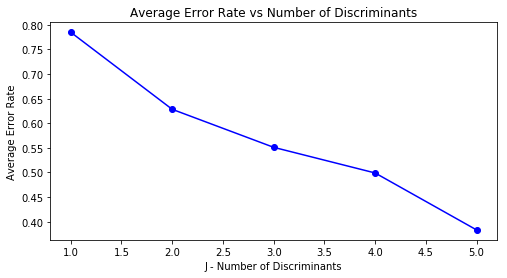

In [139]:
N = len(As) + len(Bs)
Avg_errors = []
Min_errors = []
Max_errors = []
Stdev_errors = []

for row in errors:  
    avg = sum(row)/len(row)
    Avg_errors.append(avg/N)  
    Min_errors.append(min(row)/N)
    Max_errors.append(max(row)/N)
           
    row = np.array(row)
    row = row/N
    Stdev_errors.append(np.std(row))       
    
print(Avg_errors)
print(Min_errors)
print(Max_errors)
print(Stdev_errors)

Text(0, 0.5, 'Average Error Rate')

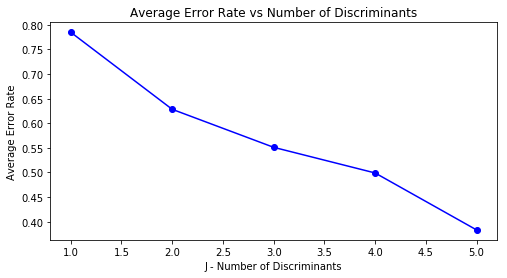

In [140]:
plt.figure(1, figsize=(8,4))
plt.plot(Js, Avg_errors, 'bo', linestyle='solid')
plt.title("Average Error Rate vs Number of Discriminants")
plt.xlabel('J - Number of Discriminants')
plt.ylabel('Average Error Rate')

Text(0, 0.5, 'Minimum Error Rate')

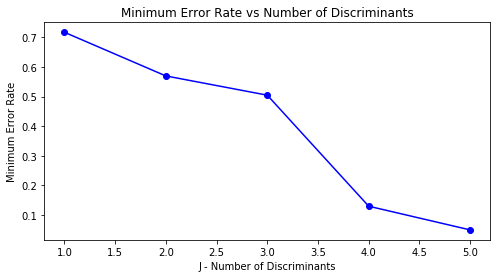

In [142]:
plt.figure(1, figsize=(8,4))
plt.plot(Js, Min_errors, 'bo', linestyle='solid')
plt.title("Minimum Error Rate vs Number of Discriminants")
plt.xlabel('J - Number of Discriminants')
plt.ylabel('Minimum Error Rate')

Text(0, 0.5, 'Maximum Error Rate')

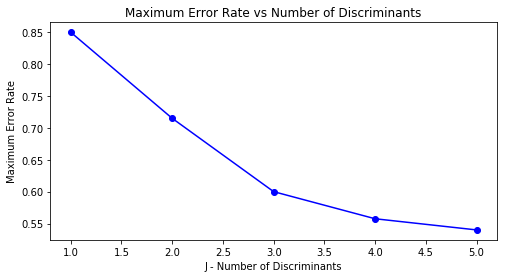

In [143]:
plt.figure(1, figsize=(8,4))
plt.plot(Js, Max_errors, 'bo', linestyle='solid')
plt.title("Maximum Error Rate vs Number of Discriminants")
plt.xlabel('J - Number of Discriminants')
plt.ylabel('Maximum Error Rate')

Text(0, 0.5, 'Standard Deviation of Error Rates')

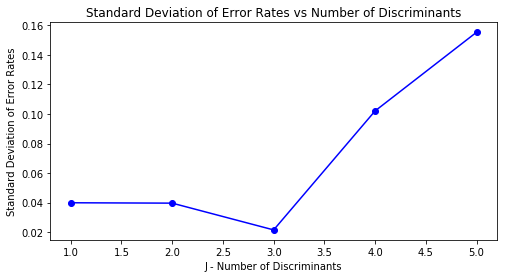

In [144]:
plt.figure(1, figsize=(8,4))
plt.plot(Js, Stdev_errors, 'bo', linestyle='solid')
plt.title("Standard Deviation of Error Rates vs Number of Discriminants")
plt.xlabel('J - Number of Discriminants')
plt.ylabel('Standard Deviation of Error Rates')